🏏 CRICKET TEAM SCORE DISTRIBUTION ANALYSIS WITH NFT TIERS

📊 Running 10,000 simulations...
⏳ This may take 2-5 minutes. Please wait...

🔍 DATA QUALITY CHECK:
   Total players in dataset: 3228

   Player distribution:
   - Bowler: 1747
   - Batsman: 1251
   - Wicketkeeper: 230

✅ Using 3228 total players

   Progress: 1,000/10,000 simulations completed...
   Progress: 2,000/10,000 simulations completed...
   Progress: 3,000/10,000 simulations completed...
   Progress: 4,000/10,000 simulations completed...
   Progress: 5,000/10,000 simulations completed...
   Progress: 6,000/10,000 simulations completed...
   Progress: 7,000/10,000 simulations completed...
   Progress: 8,000/10,000 simulations completed...
   Progress: 9,000/10,000 simulations completed...
   Progress: 10,000/10,000 simulations completed...

✅ Simulation complete! Generated 10,000 valid teams

📊 STATISTICAL SUMMARY - TEAM TOTAL SCORES (0-1000)
Highest Team Score:    745.23
Lowest Team Score:     357.38
Average Team Score

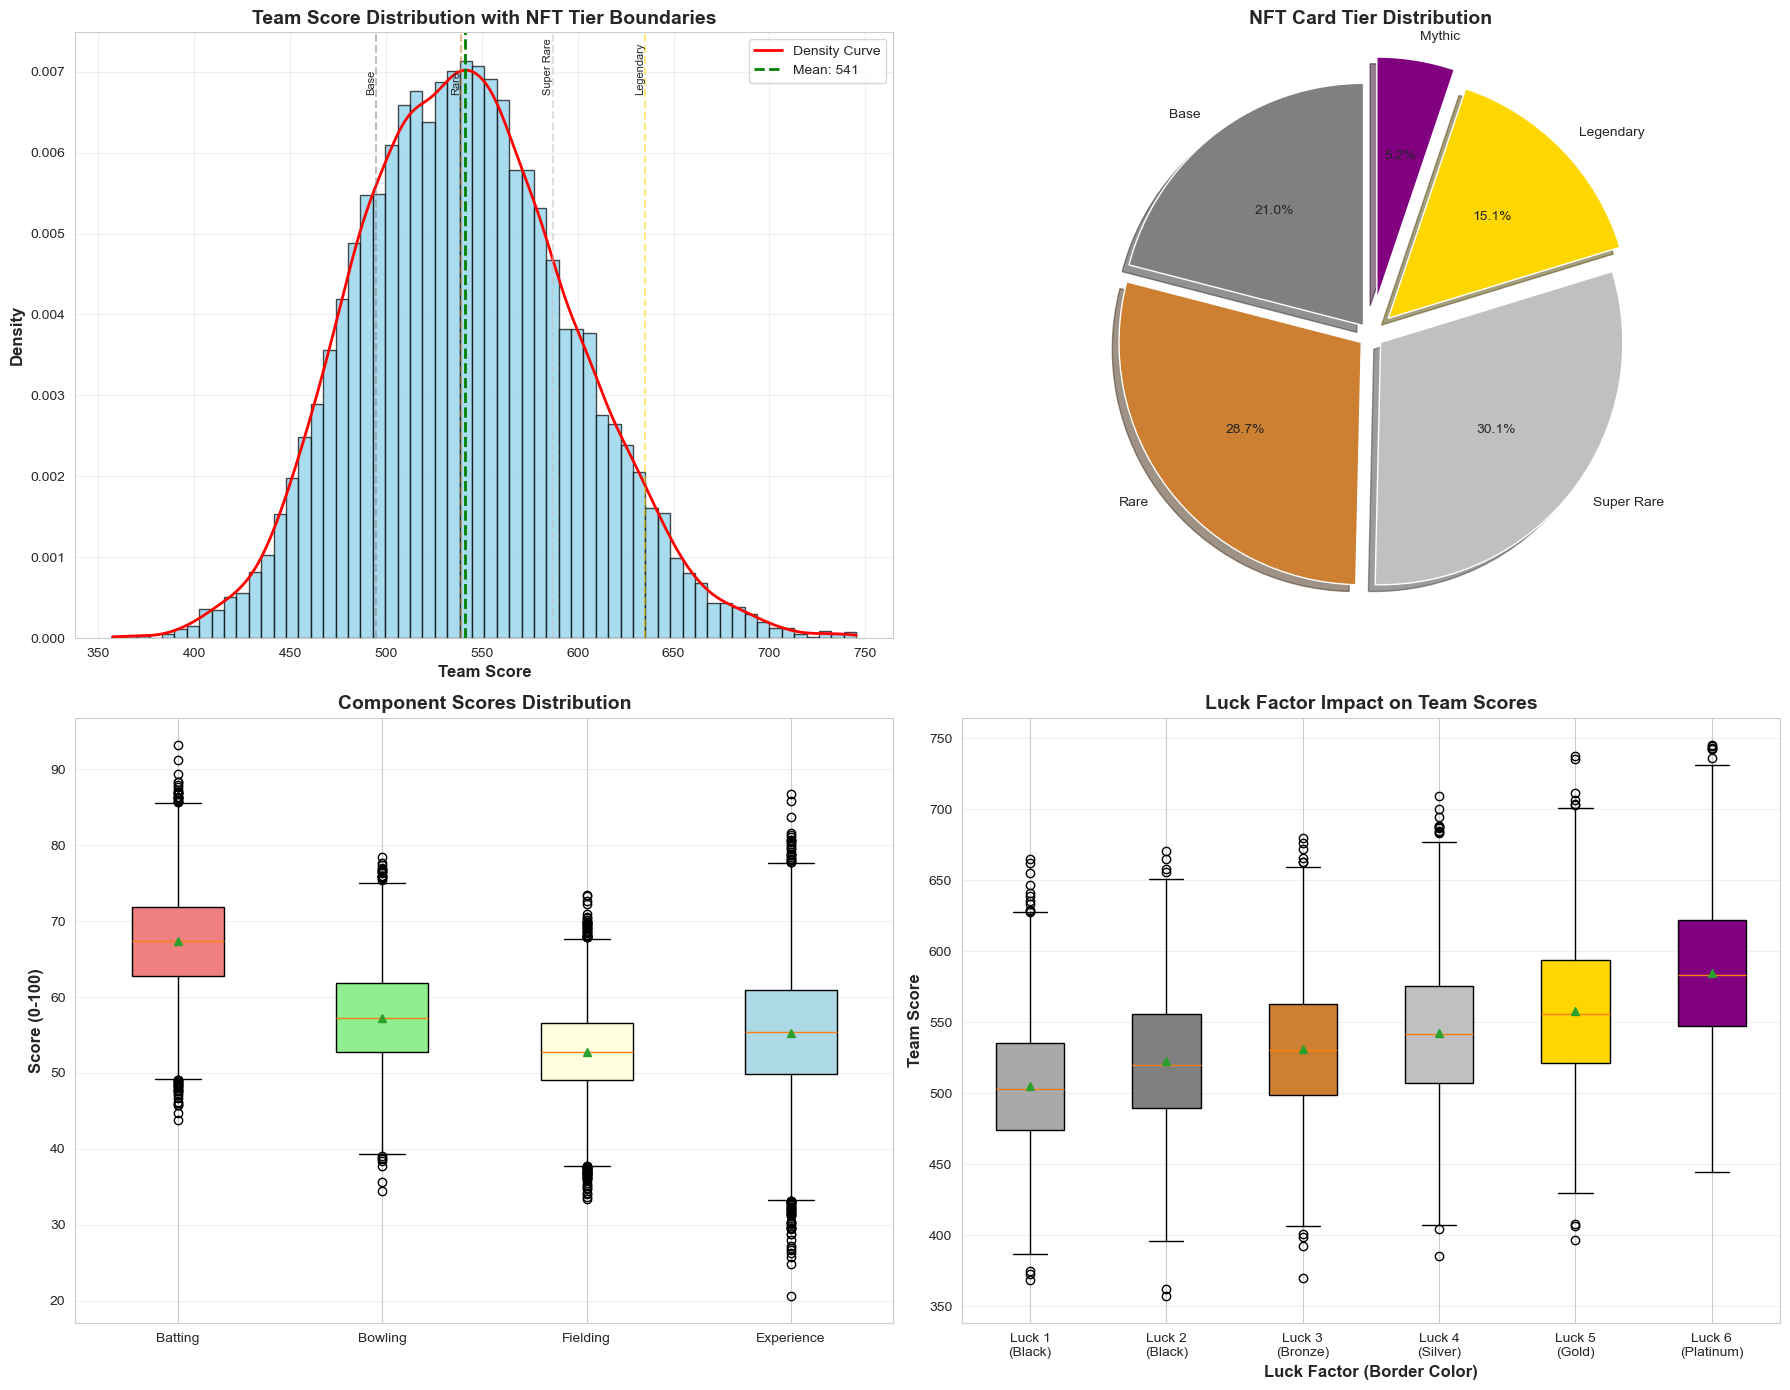

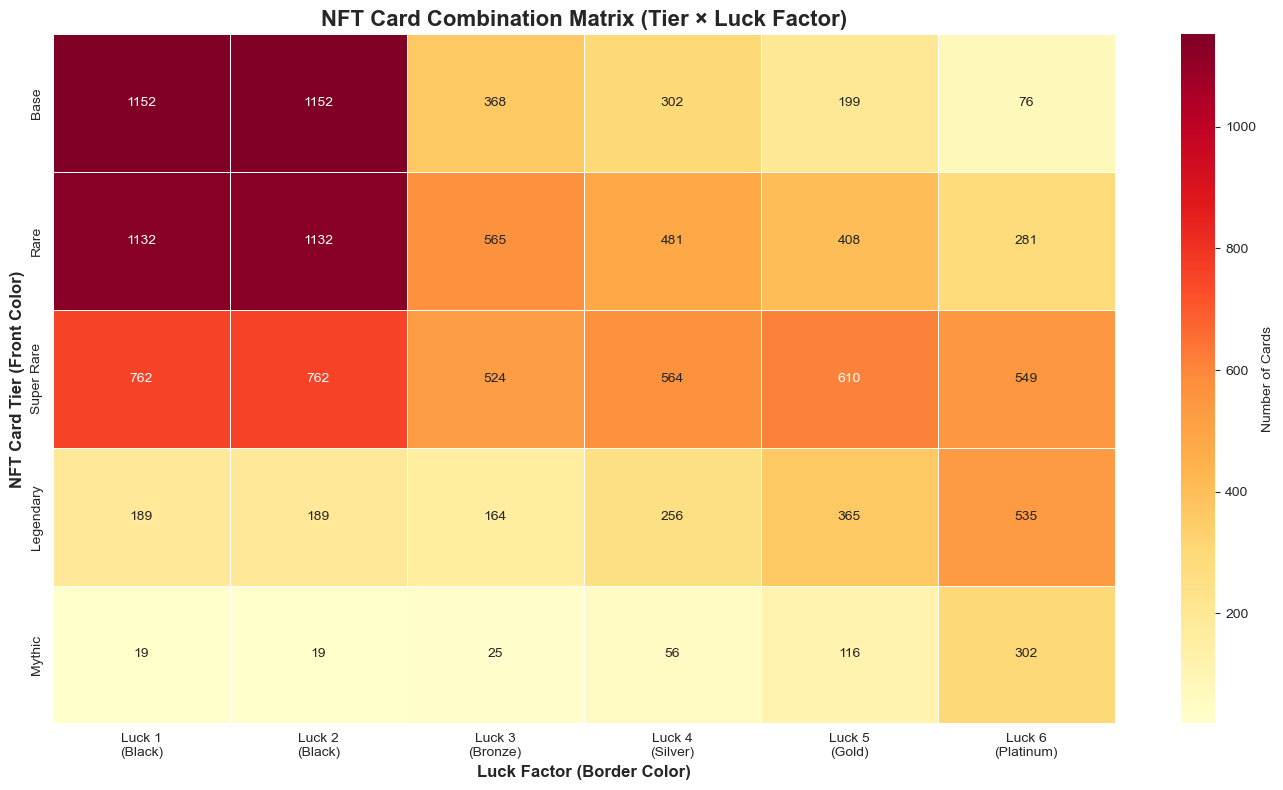


💡 NFT CARD SYSTEM RECOMMENDATIONS

📊 TIER BALANCE ANALYSIS:
Tier            Current %    Ideal %      Status              
----------------------------------------------------------------------
Base               20.97%        20.00%     ✅ Balanced          
Rare               28.67%        30.00%     ✅ Balanced          
Super Rare         30.09%        30.00%     ✅ Balanced          
Legendary          15.09%        15.00%     ✅ Balanced          
Mythic              5.18%         5.00%     ✅ Balanced          

💡 SUGGESTED TIER RANGE ADJUSTMENTS:
----------------------------------------------------------------------

Based on actual score distribution:
  Suggested Base:       0 - 493
  Suggested Rare:       493 - 539
  Suggested Super Rare: 539 - 587
  Suggested Legendary:  587 - 636
  Suggested Mythic:     636 - 1000

----------------------------------------------------------------------
Current tier ranges:
  Base           : 0 - 495
  Rare           : 495 - 539
  Super Rare     

In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# =====================================================
# CONFIGURATION
# =====================================================
DATA_FILE = "Final_Player_Stats.csv"
TEAM_SIZE = {'Batsman': 6, 'Wicketkeeper': 1, 'Bowler': 4}
NUM_SIMULATIONS = 10000

LONGEVITY_CONSTANTS = {
    'batting_k': 20,
    'league_batting_avg': 30.0,
    'bowling_k': 25,
    'league_bowling_avg': 35.0,
    'duck_k': 30
}

COMPONENT_VARIANCE = 0.05
TEAM_VARIANCE = 0.02

# =====================================================
# NFT CARD TIER SYSTEM
# =====================================================
CARD_TIERS = {
    'Base': {'range': (0, 495), 'color': 'Black', 'rarity': 'Common'},
    'Rare': {'range': (495.001, 539), 'color': 'Bronze', 'rarity': 'Rare'},
    'Super Rare': {'range': (539.001, 587), 'color': 'Silver', 'rarity': 'Super Rare'},
    'Legendary': {'range': (587.001, 635), 'color': 'Gold', 'rarity': 'Legendary'},
    'Mythic': {'range': (635.001, 1000), 'color': 'Platinum', 'rarity': 'Mythic'}
}

LUCK_BORDER_COLORS = {
    1: 'Black',
    2: 'Black', 
    3: 'Bronze',
    4: 'Silver',
    5: 'Gold',
    6: 'Platinum'
}

def get_card_tier(score):
    """Determine card tier based on team score"""
    for tier, info in CARD_TIERS.items():
        if info['range'][0] <= score <= info['range'][1]:
            return tier, info['color']
    return 'Mythic', 'Platinum'  # Fallback for edge cases

def get_card_name(score, luck):
    """Generate card name: 'Front Color / Border Color'"""
    tier, front_color = get_card_tier(score)
    border_color = LUCK_BORDER_COLORS[luck]
    return f"{front_color} / {border_color}", tier

print("="*70)
print("🏏 CRICKET TEAM SCORE DISTRIBUTION ANALYSIS WITH NFT TIERS")
print("="*70)
print(f"\n📊 Running {NUM_SIMULATIONS:,} simulations...")
print("⏳ This may take 2-5 minutes. Please wait...\n")

# =====================================================
# LOAD AND VALIDATE DATA
# =====================================================
players_df = pd.read_csv(DATA_FILE)

print("🔍 DATA QUALITY CHECK:")
print(f"   Total players in dataset: {len(players_df)}")

# Check category distribution
category_counts = players_df['Player_Category'].value_counts()
print(f"\n   Player distribution:")
for cat, count in category_counts.items():
    print(f"   - {cat}: {count}")

if 'Player_ID' not in players_df.columns:
    players_df['Player_ID'] = players_df.index

players_df['Total_Fielding'] = players_df['Stumpings_Total'] + players_df['Fielding_Catches']
print(f"\n✅ Using {len(players_df)} total players\n")

# =====================================================
# SCORING FUNCTIONS
# =====================================================

def percentile_score(value, all_values, min_score=0, max_score=100, lower_is_better=False):
    if pd.isna(value) or value < 0:
        return min_score
    valid_values = all_values[all_values.notna() & (all_values >= 0)]
    if len(valid_values) == 0:
        return min_score
    percentile = stats.percentileofscore(valid_values, value, kind='rank')
    if lower_is_better:
        percentile = 100 - percentile
    score = min_score + (percentile / 100) * (max_score - min_score)
    return np.clip(score, min_score, max_score)

def calculate_consistency_modifier(player_row):
    if player_row['Matches_Played'] < 5:
        return 1.0
    modifier = 1.0
    not_out_ratio = player_row['Not_Outs'] / max(player_row['Matches_Played'], 1)
    modifier += not_out_ratio * 0.08
    raw_duck_rate = player_row['Ducks_Career'] / max(player_row['Matches_Played'], 1)
    k = LONGEVITY_CONSTANTS['duck_k']
    typical_duck_rate = 0.15
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_duck_rate = (longevity_weight * raw_duck_rate + (1 - longevity_weight) * typical_duck_rate)
    duck_penalty = adjusted_duck_rate * 0.40
    modifier -= duck_penalty
    return np.clip(modifier, 0.85, 1.15)

def random_scale(score, max_variance=0.05):
    return score * random.uniform(1 - max_variance, 1 + max_variance)

def calculate_individual_batting_score(player_row, all_players_df):
    k = LONGEVITY_CONSTANTS['batting_k']
    league_avg = LONGEVITY_CONSTANTS['league_batting_avg']
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_batting_avg = (longevity_weight * player_row['Batting_Average'] + 
                            (1 - longevity_weight) * league_avg)
    avg_score = percentile_score(adjusted_batting_avg, all_players_df['Batting_Average'], 0, 100)
    runs_score = percentile_score(player_row['Total_Runs'], all_players_df['Total_Runs'], 0, 100)
    centuries_score = percentile_score(player_row['Centuries'], all_players_df['Centuries'], 0, 100)
    fifties_score = percentile_score(player_row['Fifties'], all_players_df['Fifties'], 0, 100)
    consistency = calculate_consistency_modifier(player_row)
    batting_score = (avg_score * 0.35 + runs_score * 0.25 + 
                     centuries_score * 0.20 + fifties_score * 0.20) * consistency
    return np.clip(batting_score, 0, 100)

def calculate_individual_bowling_score(player_row, all_players_df):
    k = LONGEVITY_CONSTANTS['bowling_k']
    league_avg = LONGEVITY_CONSTANTS['league_bowling_avg']
    longevity_weight = player_row['Matches_Played'] / (player_row['Matches_Played'] + k)
    adjusted_bowling_avg = (longevity_weight * player_row['Bowling_Average'] + 
                            (1 - longevity_weight) * league_avg)
    avg_score = percentile_score(adjusted_bowling_avg, all_players_df['Bowling_Average'], 
                                  0, 100, lower_is_better=True)
    wickets_score = percentile_score(player_row['Wickets_Total'], all_players_df['Wickets_Total'], 0, 100)
    five_wickets_score = percentile_score(player_row['Five_Wickets'], all_players_df['Five_Wickets'], 0, 100)
    matches_score = percentile_score(player_row['Matches_Played'], all_players_df['Matches_Played'], 0, 100)
    bowling_score = (avg_score * 0.35 + wickets_score * 0.30 + 
                     five_wickets_score * 0.20 + matches_score * 0.15)
    return np.clip(bowling_score, 0, 100)

def calculate_individual_fielding_score(player_row, all_players_df):
    catches_score = percentile_score(player_row['Fielding_Catches'], 
                                     all_players_df['Fielding_Catches'], 0, 100)
    stumpings_score = percentile_score(player_row['Stumpings_Total'], 
                                       all_players_df['Stumpings_Total'], 0, 100)
    if player_row['Player_Category'] == 'Wicketkeeper':
        stumpings_score = np.clip(stumpings_score * 1.2, 0, 100)
    fielding_score = catches_score * 0.65 + stumpings_score * 0.35
    return np.clip(fielding_score, 0, 100)

def calculate_individual_experience_score(player_row, all_players_df):
    matches_score = percentile_score(player_row['Matches_Played'], 
                                     all_players_df['Matches_Played'], 0, 100)
    return np.clip(matches_score, 0, 100)

# =====================================================
# TEAM GENERATION AND SCORING
# =====================================================

def generate_team_score():
    """Generate one team and return its score and metadata"""
    batsmen_pool = players_df[players_df['Player_Category'] == 'Batsman']
    keepers_pool = players_df[players_df['Player_Category'] == 'Wicketkeeper']
    bowlers_pool = players_df[players_df['Player_Category'] == 'Bowler']
    
    if len(batsmen_pool) < TEAM_SIZE['Batsman'] or \
       len(keepers_pool) < TEAM_SIZE['Wicketkeeper'] or \
       len(bowlers_pool) < TEAM_SIZE['Bowler']:
        return None
    
    team_batsmen = batsmen_pool.sample(TEAM_SIZE['Batsman'], random_state=random.randint(1, 99999))
    team_keeper = keepers_pool.sample(TEAM_SIZE['Wicketkeeper'], random_state=random.randint(1, 99999))
    team_bowlers = bowlers_pool.sample(TEAM_SIZE['Bowler'], random_state=random.randint(1, 99999))
    
    team_df = pd.concat([team_batsmen, team_keeper, team_bowlers]).reset_index(drop=True)
    
    # Calculate individual scores
    team_df['Individual_Batting_Score'] = team_df.apply(
        lambda row: calculate_individual_batting_score(row, players_df), axis=1
    )
    team_df['Individual_Bowling_Score'] = team_df.apply(
        lambda row: calculate_individual_bowling_score(row, players_df), axis=1
    )
    team_df['Individual_Fielding_Score'] = team_df.apply(
        lambda row: calculate_individual_fielding_score(row, players_df), axis=1
    )
    team_df['Individual_Experience_Score'] = team_df.apply(
        lambda row: calculate_individual_experience_score(row, players_df), axis=1
    )
    
    team_df['Individual_Total_Score'] = (
        team_df['Individual_Batting_Score'] * 0.35 +
        team_df['Individual_Bowling_Score'] * 0.35 +
        team_df['Individual_Fielding_Score'] * 0.15 +
        team_df['Individual_Experience_Score'] * 0.15
    )
    
    # Team component scores
    batting_contributors = team_df[team_df['Player_Category'].isin(['Batsman', 'Wicketkeeper'])].nlargest(7, 'Individual_Batting_Score')
    weights_batting = [1.25, 1.20, 1.15, 1.10, 1.05, 1.0, 1.0][:len(batting_contributors)]
    team_batting_score = np.average(batting_contributors['Individual_Batting_Score'].values, weights=weights_batting)
    team_batting_score = random_scale(team_batting_score, COMPONENT_VARIANCE)
    team_batting_score = np.clip(team_batting_score, 0, 100)
    
    bowling_contributors = team_df.nlargest(5, 'Individual_Bowling_Score')
    weights_bowling = [1.30, 1.20, 1.10, 1.0, 1.0][:len(bowling_contributors)]
    team_bowling_score = np.average(bowling_contributors['Individual_Bowling_Score'].values, weights=weights_bowling)
    team_bowling_score = random_scale(team_bowling_score, COMPONENT_VARIANCE)
    team_bowling_score = np.clip(team_bowling_score, 0, 100)
    
    team_fielding_score = team_df['Individual_Fielding_Score'].mean()
    team_fielding_score = random_scale(team_fielding_score, COMPONENT_VARIANCE)
    team_fielding_score = np.clip(team_fielding_score, 0, 100)
    
    exp_sorted = team_df.sort_values('Individual_Experience_Score', ascending=False)
    weights_exp = [1.20, 1.15, 1.10, 1.05, 1.0] + [0.95] * 6
    weights_exp = weights_exp[:len(exp_sorted)]
    team_experience_score = np.average(exp_sorted['Individual_Experience_Score'].values, weights=weights_exp)
    team_experience_score = random_scale(team_experience_score, COMPONENT_VARIANCE)
    team_experience_score = np.clip(team_experience_score, 0, 100)
    
    # Team total score
    raw_team_total = team_df['Individual_Total_Score'].sum()
    min_possible = 0
    max_possible = 11 * 100
    team_total_score = (raw_team_total / max_possible) * 1000
    team_total_score = np.clip(team_total_score, 0, 1000)
    team_total_score = random_scale(team_total_score, TEAM_VARIANCE)
    
    # Game variables
    home_or_away = random.choice(["Home", "Away"])
    luck_factor = random.randint(1, 6)
    luck_effect_map = {1: -0.05, 2: -0.02, 3: 0, 4: 0.02, 5: 0.05, 6: 0.10}
    
    if home_or_away == "Home":
        team_total_score *= 1.05
    else:
        team_total_score *= 0.97
    
    team_total_score *= (1 + luck_effect_map[luck_factor])
    team_total_score = np.clip(team_total_score, 0, 1000)
    
    return {
        'team_total_score': team_total_score,
        'team_batting_score': team_batting_score,
        'team_bowling_score': team_bowling_score,
        'team_fielding_score': team_fielding_score,
        'team_experience_score': team_experience_score,
        'home_away': home_or_away,
        'luck_factor': luck_factor,
        'raw_total': raw_team_total
    }

# =====================================================
# RUN SIMULATION
# =====================================================

simulation_results = []
home_scores = []
away_scores = []
luck_scores = defaultdict(list)
card_combinations = defaultdict(int)
tier_distribution = defaultdict(int)

for i in range(NUM_SIMULATIONS):
    if (i + 1) % 1000 == 0:
        print(f"   Progress: {i+1:,}/{NUM_SIMULATIONS:,} simulations completed...")
    
    result = generate_team_score()
    if result:
        simulation_results.append(result)
        
        if result['home_away'] == 'Home':
            home_scores.append(result['team_total_score'])
        else:
            away_scores.append(result['team_total_score'])
        
        luck_scores[result['luck_factor']].append(result['team_total_score'])
        
        # NFT Card tracking
        card_name, tier = get_card_name(result['team_total_score'], result['luck_factor'])
        card_combinations[card_name] += 1
        tier_distribution[tier] += 1

print(f"\n✅ Simulation complete! Generated {len(simulation_results):,} valid teams\n")

# =====================================================
# EXTRACT DATA
# =====================================================

team_scores = [r['team_total_score'] for r in simulation_results]
batting_scores = [r['team_batting_score'] for r in simulation_results]
bowling_scores = [r['team_bowling_score'] for r in simulation_results]
fielding_scores = [r['team_fielding_score'] for r in simulation_results]
experience_scores = [r['team_experience_score'] for r in simulation_results]

# =====================================================
# STATISTICAL ANALYSIS
# =====================================================

print("="*70)
print("📊 STATISTICAL SUMMARY - TEAM TOTAL SCORES (0-1000)")
print("="*70)
print(f"Highest Team Score:    {np.max(team_scores):.2f}")
print(f"Lowest Team Score:     {np.min(team_scores):.2f}")
print(f"Average Team Score:    {np.mean(team_scores):.2f}")
print(f"Median (50th %ile):    {np.median(team_scores):.2f}")
print(f"Std Deviation:         {np.std(team_scores):.2f}")
print(f"Range:                 {np.max(team_scores) - np.min(team_scores):.2f}")

print("\n" + "-"*70)
print("PERCENTILE BREAKDOWN (Every 10th Percentile)")
print("-"*70)
percentiles = np.percentile(team_scores, np.arange(0, 101, 10))
for i, pct in enumerate(np.arange(0, 101, 10)):
    print(f"{pct:3d}th Percentile: {percentiles[i]:7.2f}")

print("\n" + "-"*70)
print("SCORE RANGES (What % of teams fall in each range?)")
print("-"*70)
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]
for low, high in ranges:
    count = sum(1 for s in team_scores if low <= s < high)
    percentage = (count / len(team_scores)) * 100
    print(f"{low:4d}-{high:4d}: {count:5d} teams ({percentage:5.2f}%)")

# =====================================================
# NFT CARD TIER ANALYSIS
# =====================================================

print("\n" + "="*70)
print("🎴 NFT CARD TIER DISTRIBUTION")
print("="*70)

tier_order = ['Base', 'Rare', 'Super Rare', 'Legendary', 'Mythic']
print(f"{'Tier':<15} {'Score Range':<20} {'Count':<10} {'Percentage':<12} {'Color':<10}")
print("-"*70)
for tier in tier_order:
    count = tier_distribution[tier]
    percentage = (count / len(simulation_results)) * 100
    tier_info = CARD_TIERS[tier]
    score_range = f"{tier_info['range'][0]:.0f}-{tier_info['range'][1]:.0f}"
    color = tier_info['color']
    print(f"{tier:<15} {score_range:<20} {count:<10} {percentage:>5.2f}%       {color:<10}")

# =====================================================
# LUCK FACTOR IMPACT ON TIERS
# =====================================================

print("\n" + "="*70)
print("🎲 LUCK FACTOR IMPACT BY SCORE")
print("="*70)
print(f"{'Luck':<8} {'Border Color':<15} {'Count':<8} {'Mean Score':<12} {'Median':<12}")
print("-"*70)
for luck in sorted(luck_scores.keys()):
    scores = luck_scores[luck]
    border_color = LUCK_BORDER_COLORS[luck]
    print(f"{luck:<8} {border_color:<15} {len(scores):<8} {np.mean(scores):<12.2f} {np.median(scores):<12.2f}")

# =====================================================
# TOP 10 RAREST CARD COMBINATIONS
# =====================================================

print("\n" + "="*70)
print("💎 TOP 10 RAREST CARD COMBINATIONS")
print("="*70)
sorted_cards = sorted(card_combinations.items(), key=lambda x: x[1])
print(f"{'Card Name':<30} {'Count':<10} {'Percentage':<12} {'Rarity':<15}")
print("-"*70)
for card_name, count in sorted_cards[:10]:
    percentage = (count / len(simulation_results)) * 100
    if percentage < 0.1:
        rarity = "ULTRA RARE 🔥"
    elif percentage < 0.5:
        rarity = "VERY RARE ⭐"
    elif percentage < 1.0:
        rarity = "RARE ✨"
    else:
        rarity = "UNCOMMON"
    print(f"{card_name:<30} {count:<10} {percentage:>5.3f}%       {rarity:<15}")

# =====================================================
# TOP 10 MOST COMMON CARD COMBINATIONS
# =====================================================

print("\n" + "="*70)
print("📦 TOP 10 MOST COMMON CARD COMBINATIONS")
print("="*70)
print(f"{'Card Name':<30} {'Count':<10} {'Percentage':<12}")
print("-"*70)
for card_name, count in sorted(card_combinations.items(), key=lambda x: x[1], reverse=True)[:10]:
    percentage = (count / len(simulation_results)) * 100
    print(f"{card_name:<30} {count:<10} {percentage:>5.2f}%")

# =====================================================
# COMPONENT SCORE ANALYSIS
# =====================================================

print("\n" + "="*70)
print("🎯 COMPONENT SCORES ANALYSIS (0-100)")
print("="*70)

components = {
    'Batting': batting_scores,
    'Bowling': bowling_scores,
    'Fielding': fielding_scores,
    'Experience': experience_scores
}

print(f"{'Component':<15} {'Mean':<8} {'Median':<8} {'Std Dev':<8} {'Min':<8} {'Max':<8}")
print("-"*70)
for name, scores in components.items():
    print(f"{name:<15} {np.mean(scores):<8.2f} {np.median(scores):<8.2f} "
          f"{np.std(scores):<8.2f} {np.min(scores):<8.2f} {np.max(scores):<8.2f}")

# =====================================================
# HOME/AWAY ANALYSIS
# =====================================================

print("\n" + "="*70)
print("🏠 HOME vs AWAY IMPACT")
print("="*70)
print(f"Home teams (n={len(home_scores):,}):")
print(f"  Mean: {np.mean(home_scores):.2f}")
print(f"  Median: {np.median(home_scores):.2f}")
print(f"\nAway teams (n={len(away_scores):,}):")
print(f"  Mean: {np.mean(away_scores):.2f}")
print(f"  Median: {np.median(away_scores):.2f}")
print(f"\nDifference: {np.mean(home_scores) - np.mean(away_scores):.2f} points")
print(f"Home advantage: {((np.mean(home_scores) / np.mean(away_scores)) - 1) * 100:.2f}%")

# =====================================================
# VISUALIZATIONS
# =====================================================

print("\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS...")
print("="*70)

# Figure 1: Main distribution with NFT tiers
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Histogram with tier boundaries
axes[0, 0].hist(team_scores, bins=60, alpha=0.7, color='skyblue', edgecolor='black', density=True)
from scipy.stats import gaussian_kde
kde = gaussian_kde(team_scores)
x_range = np.linspace(min(team_scores), max(team_scores), 200)
axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density Curve')

# Add tier boundaries
tier_colors = {'Base': 'gray', 'Rare': '#CD7F32', 'Super Rare': 'silver', 'Legendary': 'gold', 'Mythic': 'purple'}
for tier in tier_order:
    tier_info = CARD_TIERS[tier]
    boundary = tier_info['range'][1]
    if boundary < 1000:
        axes[0, 0].axvline(boundary, color=tier_colors.get(tier, 'black'), 
                          linestyle='--', alpha=0.5, linewidth=1.5)
        axes[0, 0].text(boundary, axes[0, 0].get_ylim()[1] * 0.9, tier, 
                       rotation=90, fontsize=8, ha='right')

axes[0, 0].axvline(np.mean(team_scores), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(team_scores):.0f}')
axes[0, 0].set_xlabel('Team Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Team Score Distribution with NFT Tier Boundaries', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# NFT Tier Distribution Pie Chart
tier_counts = [tier_distribution[tier] for tier in tier_order]
tier_colors_list = [tier_colors[tier] for tier in tier_order]
explode = (0.05, 0.05, 0.05, 0.1, 0.15)  # Emphasize rare tiers
axes[0, 1].pie(tier_counts, labels=tier_order, autopct='%1.1f%%', colors=tier_colors_list,
              explode=explode, shadow=True, startangle=90)
axes[0, 1].set_title('NFT Card Tier Distribution', fontsize=14, fontweight='bold')

# Component scores comparison
component_data = [batting_scores, bowling_scores, fielding_scores, experience_scores]
bp = axes[1, 0].boxplot(component_data, labels=['Batting', 'Bowling', 'Fielding', 'Experience'],
                         patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightcoral', 'lightgreen', 'lightyellow', 'lightblue']):
    patch.set_facecolor(color)
axes[1, 0].set_ylabel('Score (0-100)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Component Scores Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Luck factor impact with border colors
luck_data = [luck_scores[i] for i in sorted(luck_scores.keys())]
bp2 = axes[1, 1].boxplot(luck_data, labels=[f'Luck {i}\n({LUCK_BORDER_COLORS[i]})' for i in sorted(luck_scores.keys())],
                         patch_artist=True, showmeans=True)
border_colors_vis = ['darkgray', 'gray', '#CD7F32', 'silver', 'gold', 'purple']
for patch, color in zip(bp2['boxes'], border_colors_vis):
    patch.set_facecolor(color)
axes[1, 1].set_xlabel('Luck Factor (Border Color)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Team Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Luck Factor Impact on Team Scores', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('nft_card_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: nft_card_distribution_analysis.png")

# Figure 2: Card Combination Heatmap
fig2, ax = plt.subplots(figsize=(14, 8))

# Create matrix for heatmap
tier_names = tier_order
luck_levels = sorted(LUCK_BORDER_COLORS.keys())
matrix = np.zeros((len(tier_names), len(luck_levels)))

for i, tier in enumerate(tier_names):
    for j, luck in enumerate(luck_levels):
        tier_color = CARD_TIERS[tier]['color']
        border_color = LUCK_BORDER_COLORS[luck]
        card_name = f"{tier_color} / {border_color}"
        matrix[i, j] = card_combinations.get(card_name, 0)

# Create heatmap
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=[f'Luck {l}\n({LUCK_BORDER_COLORS[l]})' for l in luck_levels],
            yticklabels=tier_names, cbar_kws={'label': 'Number of Cards'},
            linewidths=0.5, ax=ax)
ax.set_title('NFT Card Combination Matrix (Tier × Luck Factor)', fontsize=16, fontweight='bold')
ax.set_xlabel('Luck Factor (Border Color)', fontsize=12, fontweight='bold')
ax.set_ylabel('NFT Card Tier (Front Color)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('nft_card_combination_heatmap.png', dpi=300, bbox_inches='tight')
print("   ✅ Saved: nft_card_combination_heatmap.png")

plt.show()

# =====================================================
# TIER-BASED RECOMMENDATIONS
# =====================================================

print("\n" + "="*70)
print("💡 NFT CARD SYSTEM RECOMMENDATIONS")
print("="*70)

mean_score = np.mean(team_scores)
median_score = np.median(team_scores)

# Check if tier ranges are well-balanced
print("\n📊 TIER BALANCE ANALYSIS:")
ideal_distribution = {
    'Base': 20,  # 20% should be base
    'Rare': 30,  # 30% should be rare
    'Super Rare': 30,  # 30% should be super rare
    'Legendary': 15,  # 15% should be legendary
    'Mythic': 5  # 5% should be mythic
}

print(f"{'Tier':<15} {'Current %':<12} {'Ideal %':<12} {'Status':<20}")
print("-"*70)
for tier in tier_order:
    current_pct = (tier_distribution[tier] / len(simulation_results)) * 100
    ideal_pct = ideal_distribution[tier]
    diff = current_pct - ideal_pct
    if abs(diff) < 5:
        status = "✅ Balanced"
    elif diff > 5:
        status = "⚠️ Too Frequent"
    else:
        status = "🔻 Too Rare"
    print(f"{tier:<15} {current_pct:>8.2f}%     {ideal_pct:>8.2f}%     {status:<20}")

# Suggested tier adjustments
print("\n💡 SUGGESTED TIER RANGE ADJUSTMENTS:")
print("-"*70)

# Calculate percentiles for ideal distribution
p20 = np.percentile(team_scores, 20)
p50 = np.percentile(team_scores, 50)
p80 = np.percentile(team_scores, 80)
p95 = np.percentile(team_scores, 95)

print("\nBased on actual score distribution:")
print(f"  Suggested Base:       0 - {p20:.0f}")
print(f"  Suggested Rare:       {p20:.0f} - {p50:.0f}")
print(f"  Suggested Super Rare: {p50:.0f} - {p80:.0f}")
print(f"  Suggested Legendary:  {p80:.0f} - {p95:.0f}")
print(f"  Suggested Mythic:     {p95:.0f} - 1000")

print("\n" + "-"*70)
print("Current tier ranges:")
for tier in tier_order:
    tier_info = CARD_TIERS[tier]
    print(f"  {tier:<15}: {tier_info['range'][0]:.0f} - {tier_info['range'][1]:.0f}")

# Rarity insights
print("\n" + "="*70)
print("🔥 ULTRA RARE CARD INSIGHTS")
print("="*70)

mythic_platinum = card_combinations.get('Platinum / Platinum', 0)
mythic_gold = card_combinations.get('Platinum / Gold', 0)
gold_platinum = card_combinations.get('Gold / Platinum', 0)

print(f"\nRarest card combinations:")
print(f"  Platinum / Platinum: {mythic_platinum} cards ({(mythic_platinum/len(simulation_results)*100):.3f}%)")
print(f"  Platinum / Gold:     {mythic_gold} cards ({(mythic_gold/len(simulation_results)*100):.3f}%)")
print(f"  Gold / Platinum:     {gold_platinum} cards ({(gold_platinum/len(simulation_results)*100):.3f}%)")

ultra_rare_threshold = len(simulation_results) * 0.001  # Less than 0.1%
ultra_rare_cards = [card for card, count in card_combinations.items() if count < ultra_rare_threshold]

print(f"\n💎 Total ULTRA RARE combinations (<0.1%): {len(ultra_rare_cards)}")
if len(ultra_rare_cards) > 0:
    print("   These cards could be marketed as 'Limited Edition' or 'Collector's Items'")

# Business insights
print("\n" + "="*70)
print("📈 BUSINESS INSIGHTS FOR CARD DROPS")
print("="*70)

print("\nExpected drop rates (per 1000 cards opened):")
for tier in tier_order:
    count_per_1000 = (tier_distribution[tier] / len(simulation_results)) * 1000
    print(f"  {tier:<15}: ~{count_per_1000:.0f} cards")

print("\nRarity marketing suggestions:")
print("  • Base (Black):       'Common' - Easy to obtain")
print("  • Rare (Bronze):      'Uncommon' - Regular players")
print("  • Super Rare (Silver): 'Rare' - Strong teams")
print("  • Legendary (Gold):   'Epic' - Elite teams")
print("  • Mythic (Platinum):  'Legendary' - Ultra rare collector items")

# Score distribution health check
print("\n" + "="*70)
print("🏥 SCORING SYSTEM HEALTH CHECK")
print("="*70)

std_score = np.std(team_scores)
score_range = np.max(team_scores) - np.min(team_scores)

if mean_score < 400:
    print("⚠️  Average score is LOW (<400). Consider:")
    print("    - Increasing component weights for batting/bowling")
    print("    - Reducing penalties (duck punishment, consistency)")
elif mean_score > 600:
    print("⚠️  Average score is HIGH (>600). Consider:")
    print("    - Decreasing component weights")
    print("    - Increasing penalties")
else:
    print("✅  Average score is well-centered (400-600 range)")

if std_score < 50:
    print("\n⚠️  Low variance (<50). Scores are too clustered.")
    print("    - Increase COMPONENT_VARIANCE or TEAM_VARIANCE")
elif std_score > 150:
    print("\n⚠️  High variance (>150). Scores are too spread.")
    print("    - Decrease variance parameters")
else:
    print("\n✅  Variance is appropriate (50-150 range)")

if score_range > 700:
    print("\n⚠️  Score range is very wide (>700).")
    print("    - Check for outlier teams")
else:
    print("\n✅  Score range is reasonable (<700)")

# Final summary
print("\n" + "="*70)
print("✅ SIMULATION ANALYSIS COMPLETE!")
print("="*70)

print(f"\n📊 Key Statistics:")
print(f"   • Total simulations: {len(simulation_results):,}")
print(f"   • Score range: {np.min(team_scores):.2f} - {np.max(team_scores):.2f}")
print(f"   • Average score: {mean_score:.2f}")
print(f"   • Most common tier: {max(tier_distribution, key=tier_distribution.get)}")
print(f"   • Rarest tier: {min(tier_distribution, key=tier_distribution.get)}")

print(f"\n📁 Output files generated:")
print("   1. nft_card_distribution_analysis.png - Main distribution charts")
print("   2. nft_card_combination_heatmap.png - Card combination matrix")

print(f"\n🎴 NFT Card System:")
print(f"   • Total unique combinations: {len(card_combinations)}")
print(f"   • Ultra rare cards (<0.1%): {len(ultra_rare_cards)}")
print(f"   • Most common card: {max(card_combinations, key=card_combinations.get)}")
print(f"   • Rarest card: {min(card_combinations, key=card_combinations.get)}")

print("\n💡 Next Steps:")
print("   1. Review tier balance - adjust ranges if needed")
print("   2. Use suggested percentile-based ranges for better distribution")
print("   3. Market ultra-rare combinations as premium collectibles")
print("   4. Set UI thresholds based on percentile data")
print("   5. Communicate expected drop rates to users")

print("\n" + "="*70)
print("🏏 Thank you for using the Cricket Team Score Analyzer!")
print("="*70)